In [ ]:
# Modelling and Evaluation

## Objectives

- Fulfill Business Requirement 2:
  - Develop a model to classify a cherry leaf as healthy or affected by powdery mildew.

## Inputs

- Image shape embeddings file (pickle format)
- Directory structure:
  ```bash
  ├── inputs 
  │       └── cherry-leaves
  │           ├── test
  │           │   ├── healthy
  │           │   └── powdery_mildew
  │           ├── train
  │           │   ├── healthy
  │           │   └── powdery_mildew
  │           └── validation
  │               ├── healthy
  │               └── powdery_mildew
  ```

## Outputs

- Data distribution visualizations for training, validation, and testing:
  - Bar chart for label distribution
  - Pie chart for dataset split
- Image augmentation samples per dataset split.
- Class indices for labeling predictions.
- Model summary and training configurations.
- Model training results and saved model file.
- Learning curves for model performance:
  - Model A - separate plots for accuracy and loss
  - Model B - complete training history visualization
  - Model C - comprehensive training history using Plotly
- Model evaluation metrics:
  - Accuracy score
  - ROC curve
  - Classification report for each model variation
- Confusion Matrix display.
- Save evaluation as a pickle file.
- Prediction testing on a random image.

## Comments | Insights | Conclusions

- Multiple visualizations are provided to support in-depth data analysis.
- The CNN model architecture aims to achieve high accuracy with minimal overfitting.
- Documentation on hyperparameter tuning is available in README.md and a detailed PDF report.

## Import Libraries

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from matplotlib.image import imread

---

## Set Working Directory

In [25]:
cwd = os.getcwd()

In [ ]:
os.chdir('/workspaces/CI_PP5')
print("Working directory set to /workspaces/CI_PP5")

In [26]:
work_dir = os.getcwd()
work_dir

'/workspaces/CI_PP5'

## Set Input Directories

Define paths for train, validation, and test directories.

In [27]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directory

In [28]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Older version exists; consider creating a new version.')
else:
    os.makedirs(name=file_path)
    print(f"Output directory created: {file_path}")

Older version exists; consider creating a new version.


## Define Image Labels

In [29]:
labels = os.listdir(train_path)
print('Image labels are:', labels)

Image labels are: ['healthy', 'powdery_mildew']


## Load Image Shape

In [30]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Analyze Image Distribution

### Install and update nbformat, kaleido to Display the Plotly Figure.

In [23]:
!pip install nbformat --upgrade
!pip install kaleido

### Count Images in Each Set and Label Category

In [31]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




### Bar Chart for Label Distribution

In [33]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Distribution of Cherry Leaves Dataset")
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'{file_path}/image_distribution_bar.png')

### Pie Chart for Set Distribution

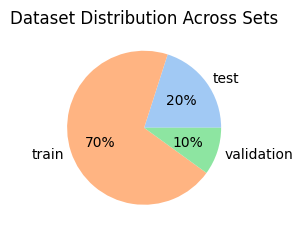

In [34]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    total = 0
    for label in labels:
        n = int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        total += n
    data.append(total)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels=folders, colors=colors, autopct='%.0f%%')
plt.title('Dataset Distribution Across Sets')
plt.savefig(f'{file_path}/set_distribution_pie.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image Data Augmentation

### Import ImageDataGenerator

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize Image Augmentation Parameters

In [36]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Define Batch Size

In [ ]:
batch_size = 8

### Augment Training Image Set

In [38]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Training Images

(16, 256, 256, 3)


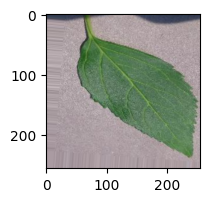

(16, 256, 256, 3)


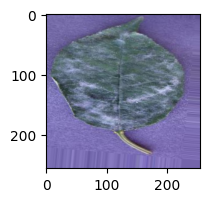

(16, 256, 256, 3)


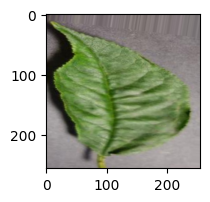

In [39]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Validation Image Set

In [40]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Validation Images

(16, 256, 256, 3)


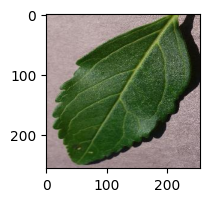

(16, 256, 256, 3)


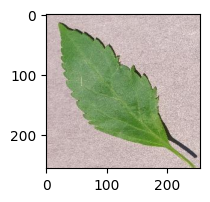

(16, 256, 256, 3)


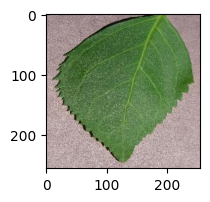

In [41]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment Test Image Set

In [42]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Display Augmented Test Images

(16, 256, 256, 3)


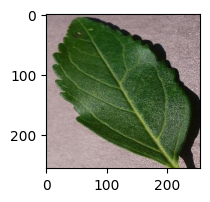

(16, 256, 256, 3)


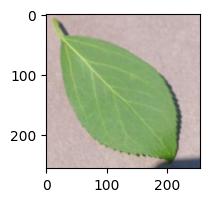

(16, 256, 256, 3)


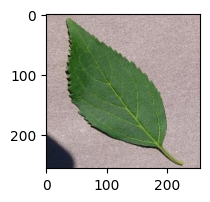

In [43]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save Class Indices

In [44]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

### Import Packages

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Define the Model

- This model will help determine if a leaf contains powdery mildew. The rationale behind model choices is detailed in the README file.
- The model addresses Business Requirement #2.

In [42]:
def create_tf_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

    return model

### Model Summary

In [43]:
create_tf_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)            

### Callbacks for Training

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

### Train the Model

In [45]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-11-06 11:07:11.413724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32


2024-11-06 11:07:11.949113: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66064384 exceeds 10% of free system memory.
2024-11-06 11:07:12.313323: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 29030400 exceeds 10% of free system memory.
2024-11-06 11:07:12.382345: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 36000000 exceeds 10% of free system memory.


  1/368 [..............................] - ETA: 7:51 - loss: 0.6621 - accuracy: 0.6250

2024-11-06 11:07:12.546986: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33032192 exceeds 10% of free system memory.
2024-11-06 11:07:12.547199: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 66064384 exceeds 10% of free system memory.


368/368 [==============================] - 215s 582ms/step - loss: 0.4887 - accuracy: 0.7571 - val_loss: 0.2828 - val_accuracy: 0.8976
Epoch 2/32
368/368 [==============================] - 209s 569ms/step - loss: 0.2935 - accuracy: 0.8791 - val_loss: 0.2572 - val_accuracy: 0.8786
Epoch 3/32
368/368 [==============================] - 205s 556ms/step - loss: 0.2301 - accuracy: 0.9120 - val_loss: 0.1669 - val_accuracy: 0.9238
Epoch 4/32
368/368 [==============================] - 202s 548ms/step - loss: 0.1617 - accuracy: 0.9457 - val_loss: 0.1221 - val_accuracy: 0.9571
Epoch 5/32
368/368 [==============================] - 200s 544ms/step - loss: 0.1231 - accuracy: 0.9657 - val_loss: 0.0820 - val_accuracy: 0.9786
Epoch 6/32
368/368 [==============================] - 200s 543ms/step - loss: 0.1045 - accuracy: 0.9698 - val_loss: 0.0959 - val_accuracy: 0.9738
Epoch 7/32
368/368 [==============================] - 200s 544ms/step - loss: 0.0889 - accuracy: 0.9779 - val_loss: 0.0624 - val_accura

### Load the Best Saved Model

In [46]:
from keras.models import load_model

best_model = load_model('outputs/v1/powdery_mildew_model.h5')

## Model Performance Visualization

### Model Learning Curve - A (Loss and Accuracy)

<Figure size 500x400 with 0 Axes>

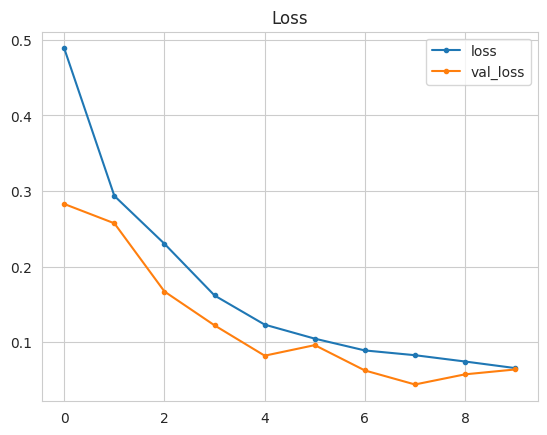

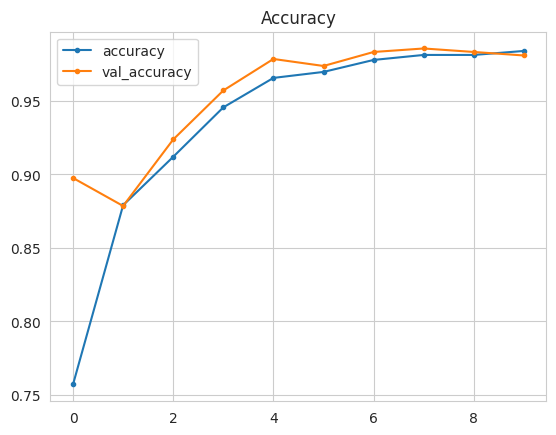

In [47]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)

losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve - B (Comprehensive View)

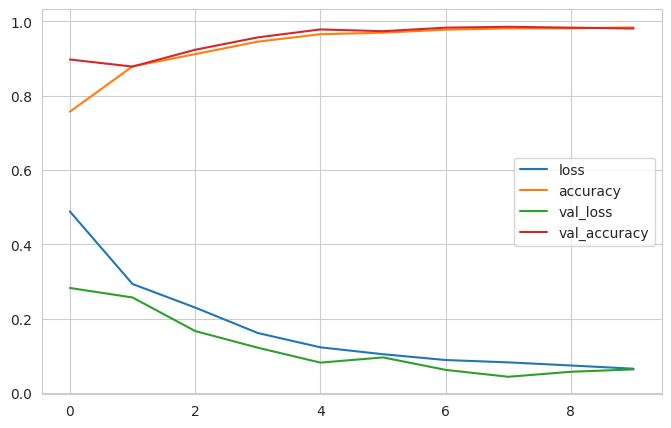

In [48]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png', bbox_inches='tight', dpi=150)
plt.show()

### Model Learning Curve - C (Detailed with Plotly)

In [49]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(y=model.history.history['val_loss'], name="val_loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=model.history.history['loss'], name="loss"), secondary_y=False)
fig.add_trace(go.Scatter(y=model.history.history['val_accuracy'], name="val_accuracy"), secondary_y=True)
fig.add_trace(go.Scatter(y=model.history.history['accuracy'], name="accuracy"), secondary_y=True)

fig.update_layout(title_text="Loss/Accuracy of Model", autosize=False, width=800, height=500)
fig.update_xaxes(title_text="Epoch")
fig.update_yaxes(title_text="<b>Primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>Secondary</b> Accuracy", secondary_y=True)

fig.show()
fig.write_image(f'{file_path}/model_history.png')